In [ ]:
Step_no = rI = dA = 1

In [ ]:
import cv2, functools, gc, glob, math, numpy as np, os, pandas, random, tensorflow as tf, time, warnings
import keras
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import Activation, add, BatchNormalization, concatenate, Conv1D, Conv2D, Conv3D, Dense, dot, Dropout
from keras.layers import Flatten, GlobalAveragePooling2D, Input, Lambda, MaxPool1D, MaxPooling2D, multiply, Reshape
from keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
from PIL import Image, ImageEnhance
from skimage import io, transform
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
warnings.filterwarnings("ignore", message = "Numerical issues were encountered")
warnings.filterwarnings("ignore", message = "Creating an ndarray from ragged nested sequences")
warnings.filterwarnings("ignore", category = DeprecationWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir = "/content/drive/MyDrive/histopathological"
doc, k, l, lastLine, classnum = open("all_files.txt",'w'), 0, 0, "", -1
for root, dir, files in os.walk(dir):
    for file in files:
        k += 1
        if file.split('.')[-1]  in ['jpg', 'JPG']:
            l += 1
            print(os.path.join(root,file), file = doc)
print(k, l)
doc.close()
list_file = open("file_list.txt","w")
with open("all_files.txt") as f:
    line = f.readline()
    while line:
        thisline = line.split("/")[-3]+line.split("/")[-2]
        if lastLine != thisline:
            classnum, lastLine = classnum + 1, thisline
        list_file.write(line.split("\n")[0]+"\t"+str(classnum)+"\n")
        line = f.readline()
f.close()
list_file.close()

226 222


In [ ]:
def creat_list(path):# called inside main Function
    global Step_no
    print(str(Step_no) + ": creat_list Function called.")
    Step_no, lists = Step_no + 1, [[] for i in range(4)]
    with open(path) as f:
        line, k = f.readline(), 0
        while line:
            classnum = int(line.split("\t")[1]) # classnum: 1 for NE, 3 for EP, 2 for EH, 0 for EA
            lists_index = 0 if classnum == 1 else 1 if classnum == 3 else 2 if classnum == 2 else 3
            lists[lists_index].append(line.split("\t")[0])
            line, k = f.readline(), k + 1
    l = {"NE": len(lists[0]), "EP": len(lists[1]), "EH": len(lists[2]), "EA": len(lists[3])}
    print(k, l)
    f.close()
    return np.array(lists, dtype=object)

In [ ]:
def slice_train_test(array, i, K): # called inside cross_validation Function
    global Step_no
    print(str(Step_no) + ": slice_train_test Function called.")
    Step_no += 1
    exp_image_cnt_in_test = len(array) // K
    test_start = i * exp_image_cnt_in_test
    test_end = test_start + exp_image_cnt_in_test
    test_array = array[test_start : test_end]
    train_array = array[ : test_start] + array[test_end : ]
    return train_array, test_array # The output is the category-wise lists of train-data paths and test-data paths

In [ ]:
def read_image_from_path_as_array(imagePath, width = 600, height = 600, normalization = True): # called inside cross_validation Function
    global Step_no, rI
    if rI == 1:
        print(str(Step_no) + ": read_image_from_path_as_array Function called.")
    Step_no, rI = Step_no + 1, rI + 1
    img = io.imread(imagePath.split('\n')[0]) # print(img) gives ndarray  # print(width, height)
    imageData = transform.resize(img, (width, height, 3))
    if normalization == True:
        imageData = np.transpose(imageData, (2, 0, 1))

        imageData = [preprocessing.scale(imageData[i]) for i in range(3)]
        imageData = np.transpose(imageData,(1, 2, 0)) # imageData = transform.resize(img,(width, height, 3))
    return imageData
    ;s, 5

In [ ]:
def _convND(ip, rank, channels): # called inside non_local_block Function
    global Step_no
    print(str(Step_no) + ": _convND Function called.")
    Step_no += 1
    assert rank in [3, 4, 5]  # Rank of input must be 3, 4 or 5
    if rank == 3:
        x = Conv1D(channels, 1, padding = 'same', use_bias = False, kernel_initializer = 'he_normal')(ip)
    elif rank == 4:
        x = Conv2D(channels, (1, 1), padding = 'same', use_bias = False, kernel_initializer = 'he_normal')(ip)
    else:
        x = Conv3D(channels, (1, 1, 1), padding = 'same', use_bias = False, kernel_initializer = 'he_normal')(ip)
    return x

In [ ]:
def non_local_block(ip, intermediate_dim = None, compression = 2, mode = 'embedded', add_residual = True): # called inside Network_Config Function
    global Step_no
    print(str(Step_no) + ": non_local_block Function called.")
    Step_no += 1
    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1
    print("K.image_data_format(): "+str(K.image_data_format()))
    ip_shape = K.int_shape(ip)
    if mode not in ['gaussian', 'embedded', 'dot', 'concatenate']:
        raise ValueError('`mode` must be one of `gaussian`, `embedded`, `dot` or `concatenate`')
    compression = 1 if compression is None else compression
    dim1, dim2, dim3 = None, None, None # check rank to calculate the input shape
    if len(ip_shape) == 3:  # temporal / time series data
        rank = 3
        batchsize, dim1, channels = ip_shape
    elif len(ip_shape) == 4:  # spatial / image data
        rank = 4
        if channel_dim == 1:
           batchsize, channels, dim1, dim2 = ip_shape
        else:
           batchsize, dim1, dim2, channels = ip_shape
    elif len(ip_shape) == 5:  # spatio-temporal / Video or Voxel data
        rank = 5
        if channel_dim == 1:
            batchsize, channels, dim1, dim2, dim3 = ip_shape
        else:
            batchsize, dim1, dim2, dim3, channels = ip_shape
    else:
        raise ValueError('Input dimension has to be either 3 (temporal), 4 (spatial) or 5 (spatio-temporal)')
    if intermediate_dim is None:
        intermediate_dim = channels // 2
        if intermediate_dim < 1:
            intermediate_dim = 1
    else:
        intermediate_dim = int(intermediate_dim)
        if intermediate_dim < 1:
            raise ValueError('`intermediate_dim` must be either `None` or positive integer greater than 1.')
    if mode == 'gaussian':  # Gaussian instantiation
        x1 = Reshape((-1, channels))(ip)  # xi
        x2 = Reshape((-1, channels))(ip)  # xj
        f = dot([x1, x2], axes = 2)
        f = Activation('softmax')(f)
    elif mode == 'dot':  # Dot instantiation
        theta = _convND(ip, rank, intermediate_dim) # theta path
        theta = Reshape((-1, intermediate_dim))(theta)
        phi = _convND(ip, rank, intermediate_dim) # phi path
        phi = Reshape((-1, intermediate_dim))(phi)
        f = dot([theta, phi], axes = 2)
        size = K.int_shape(f)
        f = Lambda(lambda z: (1. / float(size[-1])) * z)(f) # scale the values to make it size invariant
    elif mode == 'concatenate':  # Concatenation instantiation
        raise NotImplementedError('Concatenate model has not been implemented yet')
    else:  # Embedded Gaussian instantiation
        # print("ip, rank, intermediate_dim: " + str(ip) + str(rank) + str(intermediate_dim))
        theta = _convND(ip, rank, intermediate_dim) # theta path
        theta = Reshape((-1, intermediate_dim))(theta)
        phi = _convND(ip, rank, intermediate_dim) # phi path
        phi = Reshape((-1, intermediate_dim))(phi)
        if compression > 1: # shielded computation
            phi = MaxPool1D(compression)(phi)
        f = dot([theta, phi], axes = 2)
        f = Activation('softmax')(f)
    g = _convND(ip, rank, intermediate_dim) # g path
    g = Reshape((-1, intermediate_dim))(g)
    if compression > 1 and mode == 'embedded': # shielded computation
        g = MaxPool1D(compression)(g)
    y = dot([f, g], axes=[2, 1]) # compute output path
    if rank == 3: # reshape to input tensor format starts
        y = Reshape((dim1, intermediate_dim))(y)
    elif rank == 4:
        if channel_dim == -1:
            y = Reshape((dim1, dim2, intermediate_dim))(y)
        else:
            y = Reshape((intermediate_dim, dim1, dim2))(y)
    else:
        if channel_dim == -1:
            y = Reshape((dim1, dim2, dim3, intermediate_dim))(y)
        else:
            y = Reshape((intermediate_dim, dim1, dim2, dim3))(y)
    y = _convND(y, rank, channels) # project filters starts
    if add_residual: # residual connection starts
        y = concatenate([ip, y], axis = 3)
    return y

In [ ]:
def squeeze_excitation_layer(x, out_dim, ratio = 4, concate = True): # called inside Network_Config Function # inter-channel weighting.
    global Step_no
    print(str(Step_no) + ": squeeze_excitation_layer Function called.")
    Step_no += 1
    squeeze = GlobalAveragePooling2D()(x)
    excitation = Dense(units=out_dim // ratio)(squeeze)
    excitation = Activation('relu')(excitation)
    excitation = Dense(units=out_dim)(excitation)
    excitation = Activation('sigmoid')(excitation)
    excitation = Reshape((1, 1, out_dim))(excitation)
    scale = multiply([x, excitation])
    if concate:
        scale = concatenate([scale, x], axis=3)
    return scale

In [ ]:
def create_directory(dir_path): # called inside Network_Config Function
    global Step_no
    print(str(Step_no) + ": create_directory Function called.")
    Step_no += 1
    print(dir_path + " is created using create_directory Function." )
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [ ]:
def dataAugmentation(input_array, flip_left_right_rate = 0.5, flip_top_bottom_rate = 0.5): # called inside batch_generator Function
    global Step_no, dA
    if dA == 1:
        print(str(Step_no) + ": dataAugmentation Function called.")
    Step_no, dA = Step_no + 1, dA + 1
    if (random.random() < flip_left_right_rate): # Flip left and right
        input_array = np.transpose(input_array, (2, 0, 1)) # w, h, 3 -> 3, w, h
        input_array = [np.flip(input_array[i], 1) for i in range(3)]
        input_array = np.transpose(input_array, (1, 2, 0)) # 3, w, h -> w, h, 3
    if (random.random() < flip_top_bottom_rate): # Flip upside down
        input_array = np.transpose(input_array, (2, 0, 1))  # w, h, 3 -> 3, w, h
        input_array = [np.flip(input_array[i], 0) for i in range(3)]
        input_array = np.transpose(input_array, (1, 2, 0))  # 3, w, h -> w, h, 3
    return np.array(input_array)

In [ ]:
def batch_generator(all_data, all_label, batch_size, shuffle, class_num = 4, train = True): # called inside Network_Config Function
    global Step_no
    print(str(Step_no) + ": batch_generator Function called.")
    Step_no += 1
    assert len(all_data) == len(all_label)
    print("Size of all_data in batch_generator function: "+ str(len(all_data)))
    if shuffle:
        indices = np.arange(len(all_data))
        random.shuffle(indices)
    while True:
        for start_idx in range(0, len(all_data) - batch_size + 1, batch_size):
            data, labels = [], []
            excerpt = indices[start_idx : start_idx + batch_size] if shuffle else slice(start_idx, start_idx + batch_size)
            for di in excerpt:
                tmp_data = all_data[di]
                if train:
                    tmp_data = dataAugmentation(tmp_data)
                data.append(tmp_data)
            for li in excerpt:
                cla, tmp = all_label[li], [0 for x in range(class_num)]
                tmp[cla] = 1
                labels.append(tmp)
            yield np.array(data), np.array(labels)
    print("-------------------------------------------------------------------------dA: " + str(dA))

In [ ]:
def read_bottleneck(bottleneckPath):
    bottleneck = []
    bottleneckFile  =  open(bottleneckPath.split('\n')[0])
    content = bottleneckFile.read()
    feature = content.split(',')
    for i in feature[0:-1]:
        bottleneck.append(float(i))
    bottleneck = preprocessing.scale(bottleneck)
    bottleneck = np.asarray(bottleneck)
    return bottleneck


def add_array(arr1,arr2):
    for a in arr2:
        arr1.append(a)
    return arr1

In [ ]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

In [ ]:
def batch_generator_confusion_matrix(all_data, all_label, batch_size, shuffle, class_num = 4): # called inside Network_Config method
    global Step_no
    print(str(Step_no) + ": batch_generator_confusion_matrix Function called.")
    Step_no += 1
    assert len(all_data) == len(all_label)
    if shuffle:
        indices = np.arange(len(all_data))
        random.shuffle(indices)
    for start_idx in range(0, len(all_data) - batch_size + 1, batch_size):
        data, labels = [], []
        excerpt = indices[start_idx : start_idx + batch_size] if shuffle else slice(start_idx, start_idx + batch_size)
        for di in excerpt:
            tmp_data = all_data[di]
            data.append(all_data[di])
        for li in excerpt:
            cla, tmp = all_label[li], [0 for x in range(class_num)]
            tmp[cla] = 1
            labels.append(tmp)
        yield np.array(data), np.array(labels)

In [ ]:
def Network_Config(Test_data, Test_labels, Train_data = None, Train_labels = None, No_of_categories = 0, No_of_epochs = 0, Initial_epoch = 0, Batch_size = 127, Iteration_no = 0): # called inside cross_validation Function
    global Step_no
    print(str(Step_no) + ": Network_Config Function called.")
    Step_no += 1
    adam = Adam(learning_rate = 0.005, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0009)
    sgd = SGD(learning_rate = 0.001, momentum = 0.9, decay = 0.0, nesterov = False)
    input_tensor = Input(shape = (224, 224, 3))
    K.clear_session()
    base_model = VGG16(input_tensor = input_tensor, weights = 'imagenet', include_top = False)
    base_output = base_model.output
    x = non_local_block(base_output, intermediate_dim = None, compression = 2, mode = 'embedded', add_residual = False)
    x = BatchNormalization()(x)
    y = squeeze_excitation_layer(base_output, 512, ratio = 4, concate = False)
    y = BatchNormalization()(y)
    x = concatenate([base_output, x], axis = 3)
    x = concatenate([x, y], axis = 3)
    gap = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = concatenate([gap, x])
    x = Dense(512, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation = 'relu')(x)
    x = BatchNormalization()(x)
    predict = Dense(No_of_categories, activation = 'softmax')(x)
    model = Model(inputs = input_tensor, outputs = predict)
    for layer in (base_model.layers):
        layer.trainable = False
    for l in model.layers:
        print(l.name)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = [keras.metrics.categorical_accuracy])
    print("<--------------------------------------------------Model Summary--------------------------------------------------------->")
    model.summary()
    print("------------------------------------------------End of model summary------------------------------------------------------")
    create_directory('./final/')
    weights_file = './final/' + str(Iteration_no) + '-weights.{epoch:02d}-{categorical_accuracy:.4f}-{val_loss:.4f}-{val_categorical_accuracy:.4f}.h5'
    csv_file = './final/record.csv'
    lr_reducer = ReduceLROnPlateau(monitor = 'categorical_accuracy', factor = 0.2, cooldown = 0, patience = 2, min_lr = 0.5e-6)
    early_stopper = EarlyStopping(monitor = 'val_categorical_accuracy', min_delta = 1e-4, patience = 30)
    model_checkpoint = ModelCheckpoint(weights_file, monitor = 'val_categorical_accuracy', save_best_only = True, verbose = 1, save_weights_only = True, mode = 'max')
    tensorboard = TensorBoard(log_dir = './logs/', histogram_freq = 0, write_graph = True, write_images = True, embeddings_freq = 0, embeddings_layer_names = None,
                              embeddings_metadata = None)
    CSV_record = CSVLogger(csv_file, separator = ',', append = True)
    callbacks = [lr_reducer, early_stopper, model_checkpoint, tensorboard, CSV_record]
    gc.disable()
    print("Printing test label: "+ str(Test_labels))
    model.fit_generator(
        generator = batch_generator(np.array(Train_data), np.array(Train_labels), Batch_size, True, No_of_categories, True),
        steps_per_epoch = int(len(Train_labels)/Batch_size)-1,
        max_queue_size = 20,
        initial_epoch = Initial_epoch,
        epochs = No_of_epochs,
        verbose = 1,
        callbacks = callbacks,
        validation_data = batch_generator(np.array(Test_data), np.array(Test_labels), Batch_size, True, No_of_categories, False),
        validation_steps = int( len(Test_labels)/Batch_size )-1 # class_weight=NULL
        )
    print("<--------------------------------------------------Confusion Matrix process starts-------------------------------------------------->")
    Total_predicted_labels, Total_true_labels = [], []
    print("Batch size: " + str(Batch_size))
    for test_data_batch, test_labels_batch in batch_generator_confusion_matrix(np.array(Test_data), np.array(Test_labels), Batch_size, True, No_of_categories):
        print("len(test_data_batch): "+str(len(test_data_batch)))
        y_pred = model.predict(test_data_batch, Batch_size)
        y_true = test_labels_batch
        for y_p in y_pred:
            Total_predicted_labels.append(np.where(y_p == max(y_p))[0][0])
        for y_t in y_true:
            Total_true_labels.append(np.where(y_t == max(y_t))[0][0])
    confusion = confusion_matrix(y_true = Total_true_labels, y_pred = Total_predicted_labels)
    print("Total_predicted_labels: " + str(len(Total_predicted_labels)) )
    print("----------------------------------Printing confusion matrix for the iteration - " + str(Iteration_no) + "---------------------------------")
    print(confusion)
    f = open('confusion_matrix.txt','a+')
    f.write(str(Total_true_labels)+"\n")
    f.write(str(Total_predicted_labels)+"\n")
    f.write(str(confusion)+'\n')
    f.close()
    gc.enable()

In [ ]:
def cross_validation(categorised_data, K, no_of_epochs, no_of_classes, batch_size): # called inside main Function
    global Step_no
    print(str(Step_no) + ": cross_validation Function called.")
    Step_no += 1
    no_of_categories = len(categorised_data) # categorised_data = array of size 4, each index has an array of NE, EP, EH, EA
    for each_category in range(no_of_categories):
        random.shuffle(categorised_data[each_category])
    print("<--------------------------------------------------Iterations initiated-------------------------------------------------->")
    for iteration in range(K):
        print("Iteration no: %d" %iteration)
        train_data_for_present_iteration, test_data_for_present_iteration, train_data_paths, train_data_labels, test_data_paths, test_data_labels = [], [], [], [], [], []
        for category_no in range(no_of_categories):
            train_data_paths_of_each_cat, test_data_paths_of_each_cat = slice_train_test(categorised_data[category_no], iteration, K)
            print("Category-wise train-size: " + str(len(train_data_paths_of_each_cat))+ ", Category-wise test-size: " + str(len(test_data_paths_of_each_cat)))
            for each_path in range(len(train_data_paths_of_each_cat)):
                train_data_paths.append(train_data_paths_of_each_cat[each_path])
                train_data_labels.append(category_no)
            for each_path in range(len(test_data_paths_of_each_cat)):
                test_data_paths.append(test_data_paths_of_each_cat[each_path])
                test_data_labels.append(category_no)
        print("Size of training dataset: " + str(len(train_data_paths)) + ", no. of training labels: " + str(len(train_data_labels)))
        print("Size of testing dataset: " + str(len(test_data_paths)) + ", no. of testing labels: " + str(len(test_data_labels)))
        record = open("record_of_iterations.txt", 'a+')
        record.write("Iteration no: " + str(iteration))
        record.write(str(train_data_paths)+'\n')
        record.write(str(test_data_paths)+'\n')
        record.close()
        for each_path in train_data_paths:
            train_data_for_present_iteration.append(read_image_from_path_as_array(each_path, 224, 224, True))
        for each_path in test_data_paths:
            test_data_for_present_iteration.append(read_image_from_path_as_array(each_path, 224, 224, True))
        Network_Config(Train_data = train_data_for_present_iteration, No_of_categories = no_of_categories, No_of_epochs = no_of_epochs, Train_labels = train_data_labels,
                       Test_data = test_data_for_present_iteration, Test_labels = test_data_labels, Iteration_no = iteration, Initial_epoch = 0, Batch_size = batch_size)

In [ ]:
def main():
    global Step_no
    print(str(Step_no) + ": main Function called.")
    Step_no += 1
    list = creat_list("file_list.txt")
    cross_validation(categorised_data = list, K = 10, no_of_epochs = 3, no_of_classes = 4, batch_size = 10 )
main()

8174: main Function called.
8175: creat_list Function called.
222 {'NE': 50, 'EP': 25, 'EH': 25, 'EA': 122}
8176: cross_validation Function called.
<--------------------------------------------------Iterations initiated-------------------------------------------------->
Iteration no: 0
8177: slice_train_test Function called.
Category-wise train-size: 45, Category-wise test-size: 5
8178: slice_train_test Function called.
Category-wise train-size: 23, Category-wise test-size: 2
8179: slice_train_test Function called.
Category-wise train-size: 23, Category-wise test-size: 2
8180: slice_train_test Function called.
Category-wise train-size: 110, Category-wise test-size: 12
Size of training dataset: 201, no. of training labels: 201
Size of testing dataset: 21, no. of testing labels: 21
8403: Network_Config Function called.
8404: non_local_block Function called.
K.image_data_format(): channels_last
8405: _convND Function called.
8406: _convND Function called.
8407: _convND Function called.
84

<ipython-input-17-76fe69d506bd>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


19/19 [==============================] - ETA: 0s - loss: 2.6710 - categorical_accuracy: 0.47378612: batch_generator Function called.
Size of all_data in batch_generator function: 21

Epoch 1: val_categorical_accuracy improved from -inf to 0.20000, saving model to ./final/0-weights.01-0.4737-48.6544-0.2000.h5
19/19 [==============================] - 135s 7s/step - loss: 2.6710 - categorical_accuracy: 0.4737 - val_loss: 48.6544 - val_categorical_accuracy: 0.2000 - lr: 0.0050
Epoch 2/3
19/19 [==============================] - ETA: 0s - loss: 1.3183 - categorical_accuracy: 0.5684
Epoch 2: val_categorical_accuracy did not improve from 0.20000
19/19 [==============================] - 117s 6s/step - loss: 1.3183 - categorical_accuracy: 0.5684 - val_loss: 39.1240 - val_categorical_accuracy: 0.1000 - lr: 0.0050
Epoch 3/3
19/19 [==============================] - ETA: 0s - loss: 1.1004 - categorical_accuracy: 0.6053
Epoch 3: val_categorical_accuracy improved from 0.20000 to 0.70000, saving model 

<ipython-input-17-76fe69d506bd>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


19/19 [==============================] - ETA: 0s - loss: 3.1203 - categorical_accuracy: 0.46849429: batch_generator Function called.
Size of all_data in batch_generator function: 21

Epoch 1: val_categorical_accuracy improved from -inf to 0.20000, saving model to ./final/1-weights.01-0.4684-43.1488-0.2000.h5
19/19 [==============================] - 117s 6s/step - loss: 3.1203 - categorical_accuracy: 0.4684 - val_loss: 43.1488 - val_categorical_accuracy: 0.2000 - lr: 0.0050
Epoch 2/3
19/19 [==============================] - ETA: 0s - loss: 1.3285 - categorical_accuracy: 0.5684
Epoch 2: val_categorical_accuracy improved from 0.20000 to 0.60000, saving model to ./final/1-weights.02-0.5684-4.7109-0.6000.h5
19/19 [==============================] - 116s 6s/step - loss: 1.3285 - categorical_accuracy: 0.5684 - val_loss: 4.7109 - val_categorical_accuracy: 0.6000 - lr: 0.0050
Epoch 3/3
19/19 [==============================] - ETA: 0s - loss: 1.0377 - categorical_accuracy: 0.6684
Epoch 3: val_cat

<ipython-input-17-76fe69d506bd>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


19/19 [==============================] - ETA: 0s - loss: 2.7415 - categorical_accuracy: 0.426310246: batch_generator Function called.
Size of all_data in batch_generator function: 21

Epoch 1: val_categorical_accuracy improved from -inf to 0.20000, saving model to ./final/2-weights.01-0.4263-76.7427-0.2000.h5
19/19 [==============================] - 119s 6s/step - loss: 2.7415 - categorical_accuracy: 0.4263 - val_loss: 76.7427 - val_categorical_accuracy: 0.2000 - lr: 0.0050
Epoch 2/3
19/19 [==============================] - ETA: 0s - loss: 1.2610 - categorical_accuracy: 0.5895
Epoch 2: val_categorical_accuracy improved from 0.20000 to 0.50000, saving model to ./final/2-weights.02-0.5895-12.5577-0.5000.h5
19/19 [==============================] - 118s 6s/step - loss: 1.2610 - categorical_accuracy: 0.5895 - val_loss: 12.5577 - val_categorical_accuracy: 0.5000 - lr: 0.0050
Epoch 3/3
19/19 [==============================] - ETA: 0s - loss: 0.9634 - categorical_accuracy: 0.6368
Epoch 3: val_

<ipython-input-17-76fe69d506bd>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


19/19 [==============================] - ETA: 0s - loss: 2.9204 - categorical_accuracy: 0.405311063: batch_generator Function called.
Size of all_data in batch_generator function: 21

Epoch 1: val_categorical_accuracy improved from -inf to 0.30000, saving model to ./final/3-weights.01-0.4053-41.7626-0.3000.h5
19/19 [==============================] - 125s 6s/step - loss: 2.9204 - categorical_accuracy: 0.4053 - val_loss: 41.7626 - val_categorical_accuracy: 0.3000 - lr: 0.0050
Epoch 2/3
19/19 [==============================] - ETA: 0s - loss: 1.6565 - categorical_accuracy: 0.5632
Epoch 2: val_categorical_accuracy did not improve from 0.30000
19/19 [==============================] - 111s 6s/step - loss: 1.6565 - categorical_accuracy: 0.5632 - val_loss: 11.9515 - val_categorical_accuracy: 0.2000 - lr: 0.0050
Epoch 3/3
19/19 [==============================] - ETA: 0s - loss: 1.0591 - categorical_accuracy: 0.6368
Epoch 3: val_categorical_accuracy improved from 0.30000 to 0.50000, saving model

<ipython-input-17-76fe69d506bd>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


19/19 [==============================] - ETA: 0s - loss: 3.0085 - categorical_accuracy: 0.442111880: batch_generator Function called.
Size of all_data in batch_generator function: 21

Epoch 1: val_categorical_accuracy improved from -inf to 0.20000, saving model to ./final/4-weights.01-0.4421-39.4851-0.2000.h5
19/19 [==============================] - 121s 6s/step - loss: 3.0085 - categorical_accuracy: 0.4421 - val_loss: 39.4851 - val_categorical_accuracy: 0.2000 - lr: 0.0050
Epoch 2/3
19/19 [==============================] - ETA: 0s - loss: 1.3620 - categorical_accuracy: 0.5211
Epoch 2: val_categorical_accuracy improved from 0.20000 to 0.50000, saving model to ./final/4-weights.02-0.5211-6.7844-0.5000.h5
19/19 [==============================] - 115s 6s/step - loss: 1.3620 - categorical_accuracy: 0.5211 - val_loss: 6.7844 - val_categorical_accuracy: 0.5000 - lr: 0.0050
Epoch 3/3
19/19 [==============================] - ETA: 0s - loss: 1.0691 - categorical_accuracy: 0.6158
Epoch 3: val_ca

<ipython-input-17-76fe69d506bd>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


19/19 [==============================] - ETA: 0s - loss: 2.8179 - categorical_accuracy: 0.426312697: batch_generator Function called.
Size of all_data in batch_generator function: 21

Epoch 1: val_categorical_accuracy improved from -inf to 0.50000, saving model to ./final/5-weights.01-0.4263-17.3686-0.5000.h5
19/19 [==============================] - 115s 6s/step - loss: 2.8179 - categorical_accuracy: 0.4263 - val_loss: 17.3686 - val_categorical_accuracy: 0.5000 - lr: 0.0050
Epoch 2/3
19/19 [==============================] - ETA: 0s - loss: 1.4626 - categorical_accuracy: 0.6158
Epoch 2: val_categorical_accuracy did not improve from 0.50000
19/19 [==============================] - 115s 6s/step - loss: 1.4626 - categorical_accuracy: 0.6158 - val_loss: 35.3552 - val_categorical_accuracy: 0.3000 - lr: 0.0050
Epoch 3/3
19/19 [==============================] - ETA: 0s - loss: 1.0255 - categorical_accuracy: 0.6211
Epoch 3: val_categorical_accuracy did not improve from 0.50000
19/19 [==========

<ipython-input-17-76fe69d506bd>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


19/19 [==============================] - ETA: 0s - loss: 2.8641 - categorical_accuracy: 0.384213514: batch_generator Function called.
Size of all_data in batch_generator function: 21

Epoch 1: val_categorical_accuracy improved from -inf to 0.20000, saving model to ./final/6-weights.01-0.3842-67.4787-0.2000.h5
19/19 [==============================] - 111s 6s/step - loss: 2.8641 - categorical_accuracy: 0.3842 - val_loss: 67.4787 - val_categorical_accuracy: 0.2000 - lr: 0.0050
Epoch 2/3
19/19 [==============================] - ETA: 0s - loss: 1.0293 - categorical_accuracy: 0.6316
Epoch 2: val_categorical_accuracy improved from 0.20000 to 0.50000, saving model to ./final/6-weights.02-0.6316-20.3416-0.5000.h5
19/19 [==============================] - 117s 6s/step - loss: 1.0293 - categorical_accuracy: 0.6316 - val_loss: 20.3416 - val_categorical_accuracy: 0.5000 - lr: 0.0050
Epoch 3/3
19/19 [==============================] - ETA: 0s - loss: 1.1202 - categorical_accuracy: 0.6263
Epoch 3: val_

<ipython-input-17-76fe69d506bd>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


19/19 [==============================] - ETA: 0s - loss: 2.9864 - categorical_accuracy: 0.394714331: batch_generator Function called.
Size of all_data in batch_generator function: 21

Epoch 1: val_categorical_accuracy improved from -inf to 0.40000, saving model to ./final/7-weights.01-0.3947-19.3252-0.4000.h5
19/19 [==============================] - 113s 6s/step - loss: 2.9864 - categorical_accuracy: 0.3947 - val_loss: 19.3252 - val_categorical_accuracy: 0.4000 - lr: 0.0050
Epoch 2/3
19/19 [==============================] - ETA: 0s - loss: 1.5901 - categorical_accuracy: 0.5000
Epoch 2: val_categorical_accuracy did not improve from 0.40000
19/19 [==============================] - 108s 6s/step - loss: 1.5901 - categorical_accuracy: 0.5000 - val_loss: 23.8362 - val_categorical_accuracy: 0.2000 - lr: 0.0050
Epoch 3/3
19/19 [==============================] - ETA: 0s - loss: 1.1255 - categorical_accuracy: 0.6158
Epoch 3: val_categorical_accuracy did not improve from 0.40000
19/19 [==========

<ipython-input-17-76fe69d506bd>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


19/19 [==============================] - ETA: 0s - loss: 2.8777 - categorical_accuracy: 0.421115148: batch_generator Function called.
Size of all_data in batch_generator function: 21

Epoch 1: val_categorical_accuracy improved from -inf to 0.40000, saving model to ./final/8-weights.01-0.4211-26.3170-0.4000.h5
19/19 [==============================] - 117s 6s/step - loss: 2.8777 - categorical_accuracy: 0.4211 - val_loss: 26.3170 - val_categorical_accuracy: 0.4000 - lr: 0.0050
Epoch 2/3
19/19 [==============================] - ETA: 0s - loss: 1.2287 - categorical_accuracy: 0.6053
Epoch 2: val_categorical_accuracy improved from 0.40000 to 0.60000, saving model to ./final/8-weights.02-0.6053-7.1602-0.6000.h5
19/19 [==============================] - 111s 6s/step - loss: 1.2287 - categorical_accuracy: 0.6053 - val_loss: 7.1602 - val_categorical_accuracy: 0.6000 - lr: 0.0050
Epoch 3/3
19/19 [==============================] - ETA: 0s - loss: 0.9228 - categorical_accuracy: 0.6737
Epoch 3: val_ca

<ipython-input-17-76fe69d506bd>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


19/19 [==============================] - ETA: 0s - loss: 3.0862 - categorical_accuracy: 0.431615965: batch_generator Function called.
Size of all_data in batch_generator function: 21

Epoch 1: val_categorical_accuracy improved from -inf to 0.20000, saving model to ./final/9-weights.01-0.4316-100.4593-0.2000.h5
19/19 [==============================] - 117s 6s/step - loss: 3.0862 - categorical_accuracy: 0.4316 - val_loss: 100.4593 - val_categorical_accuracy: 0.2000 - lr: 0.0050
Epoch 2/3
19/19 [==============================] - ETA: 0s - loss: 1.6275 - categorical_accuracy: 0.4947
Epoch 2: val_categorical_accuracy improved from 0.20000 to 0.50000, saving model to ./final/9-weights.02-0.4947-27.1427-0.5000.h5
19/19 [==============================] - 123s 7s/step - loss: 1.6275 - categorical_accuracy: 0.4947 - val_loss: 27.1427 - val_categorical_accuracy: 0.5000 - lr: 0.0050
Epoch 3/3
19/19 [==============================] - ETA: 0s - loss: 1.0217 - categorical_accuracy: 0.6789
Epoch 3: va

In [ ]:
from keras.layers import Activation, Reshape, Lambda, dot, add,concatenate
from keras.layers import Conv1D, Conv2D, Conv3D
from keras.layers import MaxPool1D
from keras import backend as K


def non_local_block(ip, intermediate_dim=None, compression=2,
                    mode='embedded', add_residual=True):
    """
    Adds a Non-Local block for self attention to the input tensor.
    Input tensor can be or rank 3 (temporal), 4 (spatial) or 5 (spatio-temporal).

    Arguments:
        ip: input tensor
        intermediate_dim: The dimension of the intermediate representation. Can be
            `None` or a positive integer greater than 0. If `None`, computes the
            intermediate dimension as half of the input channel dimension.
        compression: None or positive integer. Compresses the intermediate
            representation during the dot products to reduce memory consumption.
            Default is set to 2, which states halve the time/space/spatio-time
            dimension for the intermediate step. Set to 1 to prevent computation
            compression. None or 1 causes no reduction.
        mode: Mode of operation. Can be one of `embedded`, `gaussian`, `dot` or
            `concatenate`.
        add_residual: Boolean value to decide if the residual connection should be
            added or not. Default is True for ResNets, and False for Self Attention.

    Returns:
        a tensor of same shape as input
    """
    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1
    ip_shape = K.int_shape(ip)

    if mode not in ['gaussian', 'embedded', 'dot', 'concatenate']:
        raise ValueError('`mode` must be one of `gaussian`, `embedded`, `dot` or `concatenate`')

    if compression is None:
        compression = 1

    dim1, dim2, dim3 = None, None, None

    # check rank and calculate the input shape
    if len(ip_shape) == 3:  # temporal / time series data
        rank = 3
        batchsize, dim1, channels = ip_shape

    elif len(ip_shape) == 4:  # spatial / image data
        rank = 4

        if channel_dim == 1:
            batchsize, channels, dim1, dim2 = ip_shape
        else:
            batchsize, dim1, dim2, channels = ip_shape

    elif len(ip_shape) == 5:  # spatio-temporal / Video or Voxel data
        rank = 5

        if channel_dim == 1:
            batchsize, channels, dim1, dim2, dim3 = ip_shape
        else:
            batchsize, dim1, dim2, dim3, channels = ip_shape

    else:
        raise ValueError('Input dimension has to be either 3 (temporal), 4 (spatial) or 5 (spatio-temporal)')

    # verify correct intermediate dimension specified
    if intermediate_dim is None:
        intermediate_dim = channels // 2

        if intermediate_dim < 1:
            intermediate_dim = 1

    else:
        intermediate_dim = int(intermediate_dim)

        if intermediate_dim < 1:
            raise ValueError('`intermediate_dim` must be either `None` or positive integer greater than 1.')

    if mode == 'gaussian':  # Gaussian instantiation
        x1 = Reshape((-1, channels))(ip)  # xi
        x2 = Reshape((-1, channels))(ip)  # xj
        f = dot([x1, x2], axes=2)
        f = Activation('softmax')(f)

    elif mode == 'dot':  # Dot instantiation
        # theta path
        theta = _convND(ip, rank, intermediate_dim)
        theta = Reshape((-1, intermediate_dim))(theta)

        # phi path
        phi = _convND(ip, rank, intermediate_dim)
        phi = Reshape((-1, intermediate_dim))(phi)

        f = dot([theta, phi], axes=2)

        size = K.int_shape(f)

        # scale the values to make it size invariant
        f = Lambda(lambda z: (1. / float(size[-1])) * z)(f)

    elif mode == 'concatenate':  # Concatenation instantiation
        raise NotImplementedError('Concatenate model has not been implemented yet')

    else:  # Embedded Gaussian instantiation
        # theta path
        theta = _convND(ip, rank, intermediate_dim)
        theta = Reshape((-1, intermediate_dim))(theta)

        # phi path
        phi = _convND(ip, rank, intermediate_dim)
        phi = Reshape((-1, intermediate_dim))(phi)

        if compression > 1:
            # shielded computation
            phi = MaxPool1D(compression)(phi)

        f = dot([theta, phi], axes=2)
        f = Activation('softmax')(f)

    # g path
    g = _convND(ip, rank, intermediate_dim)
    g = Reshape((-1, intermediate_dim))(g)

    if compression > 1 and mode == 'embedded':
        # shielded computation
        g = MaxPool1D(compression)(g)

    # compute output path
    y = dot([f, g], axes=[2, 1])

    # reshape to input tensor format
    if rank == 3:
        y = Reshape((dim1, intermediate_dim))(y)
    elif rank == 4:
        if channel_dim == -1:
            y = Reshape((dim1, dim2, intermediate_dim))(y)
        else:
            y = Reshape((intermediate_dim, dim1, dim2))(y)
    else:
        if channel_dim == -1:
            y = Reshape((dim1, dim2, dim3, intermediate_dim))(y)
        else:
            y = Reshape((intermediate_dim, dim1, dim2, dim3))(y)

    # project filters
    y = _convND(y, rank, channels)

    # residual connection
    if add_residual:
        y = concatenate([ip, y],axis=3)

    return y


def _convND(ip, rank, channels):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    if rank == 3:
        x = Conv1D(channels, 1, padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    elif rank == 4:
        x = Conv2D(channels, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    else:
        x = Conv3D(channels, (1, 1, 1), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    return x

In [ ]:
from keras.layers import Activation, Reshape, Lambda, dot, add
from keras.layers import Conv1D, Conv2D, Conv3D
from keras.layers import MaxPool1D,GlobalAveragePooling2D,Dense,multiply,Activation,concatenate
from keras import backend as K


def squeeze_excitation_layer(x, out_dim, ratio = 4, concate = True):
    '''
    SE module performs inter-channel weighting.
    '''
    squeeze = GlobalAveragePooling2D()(x)

    excitation = Dense(units=out_dim // ratio)(squeeze)
    excitation = Activation('relu')(excitation)
    excitation = Dense(units=out_dim)(excitation)
    excitation = Activation('sigmoid')(excitation)
    excitation = Reshape((1, 1, out_dim))(excitation)

    scale = multiply([x, excitation])

    if concate:
        scale = concatenate([scale, x],axis=3)
    return scale

In [ ]:
import numpy as np
import scipy as sp
import scipy.stats
import numpy


def confidenceinterval(array):
    confidence = 0.95
    a = 1.0 * np.array(array)
    m = np.mean(a)
    fc = scipy.stats.sem(a)
    h = fc * sp.stats.t._ppf((1 + confidence) / 2., n - 1) / ((n - 1) ** 0.5)
    return m - h, m + h


n = 10
a = [71,59,58]
array = numpy.asarray(a)
print(confidenceinterval(array))

(59.517250221516356, 65.81608311181697)


              precision    recall  f1-score   support

          NE       0.81      0.89      0.85        87
          EH       0.81      0.78      0.79        59
          EP       0.76      0.58      0.66        43
          EA       0.81      0.91      0.86        33

    accuracy                           0.80       222
   macro avg       0.80      0.79      0.79       222
weighted avg       0.80      0.80      0.80       222

accuracy of model	 80.18018018018019
Confusion matrix
[[77  4  5  1]
 [ 5 46  3  5]
 [13  4 25  1]
 [ 0  3  0 30]]


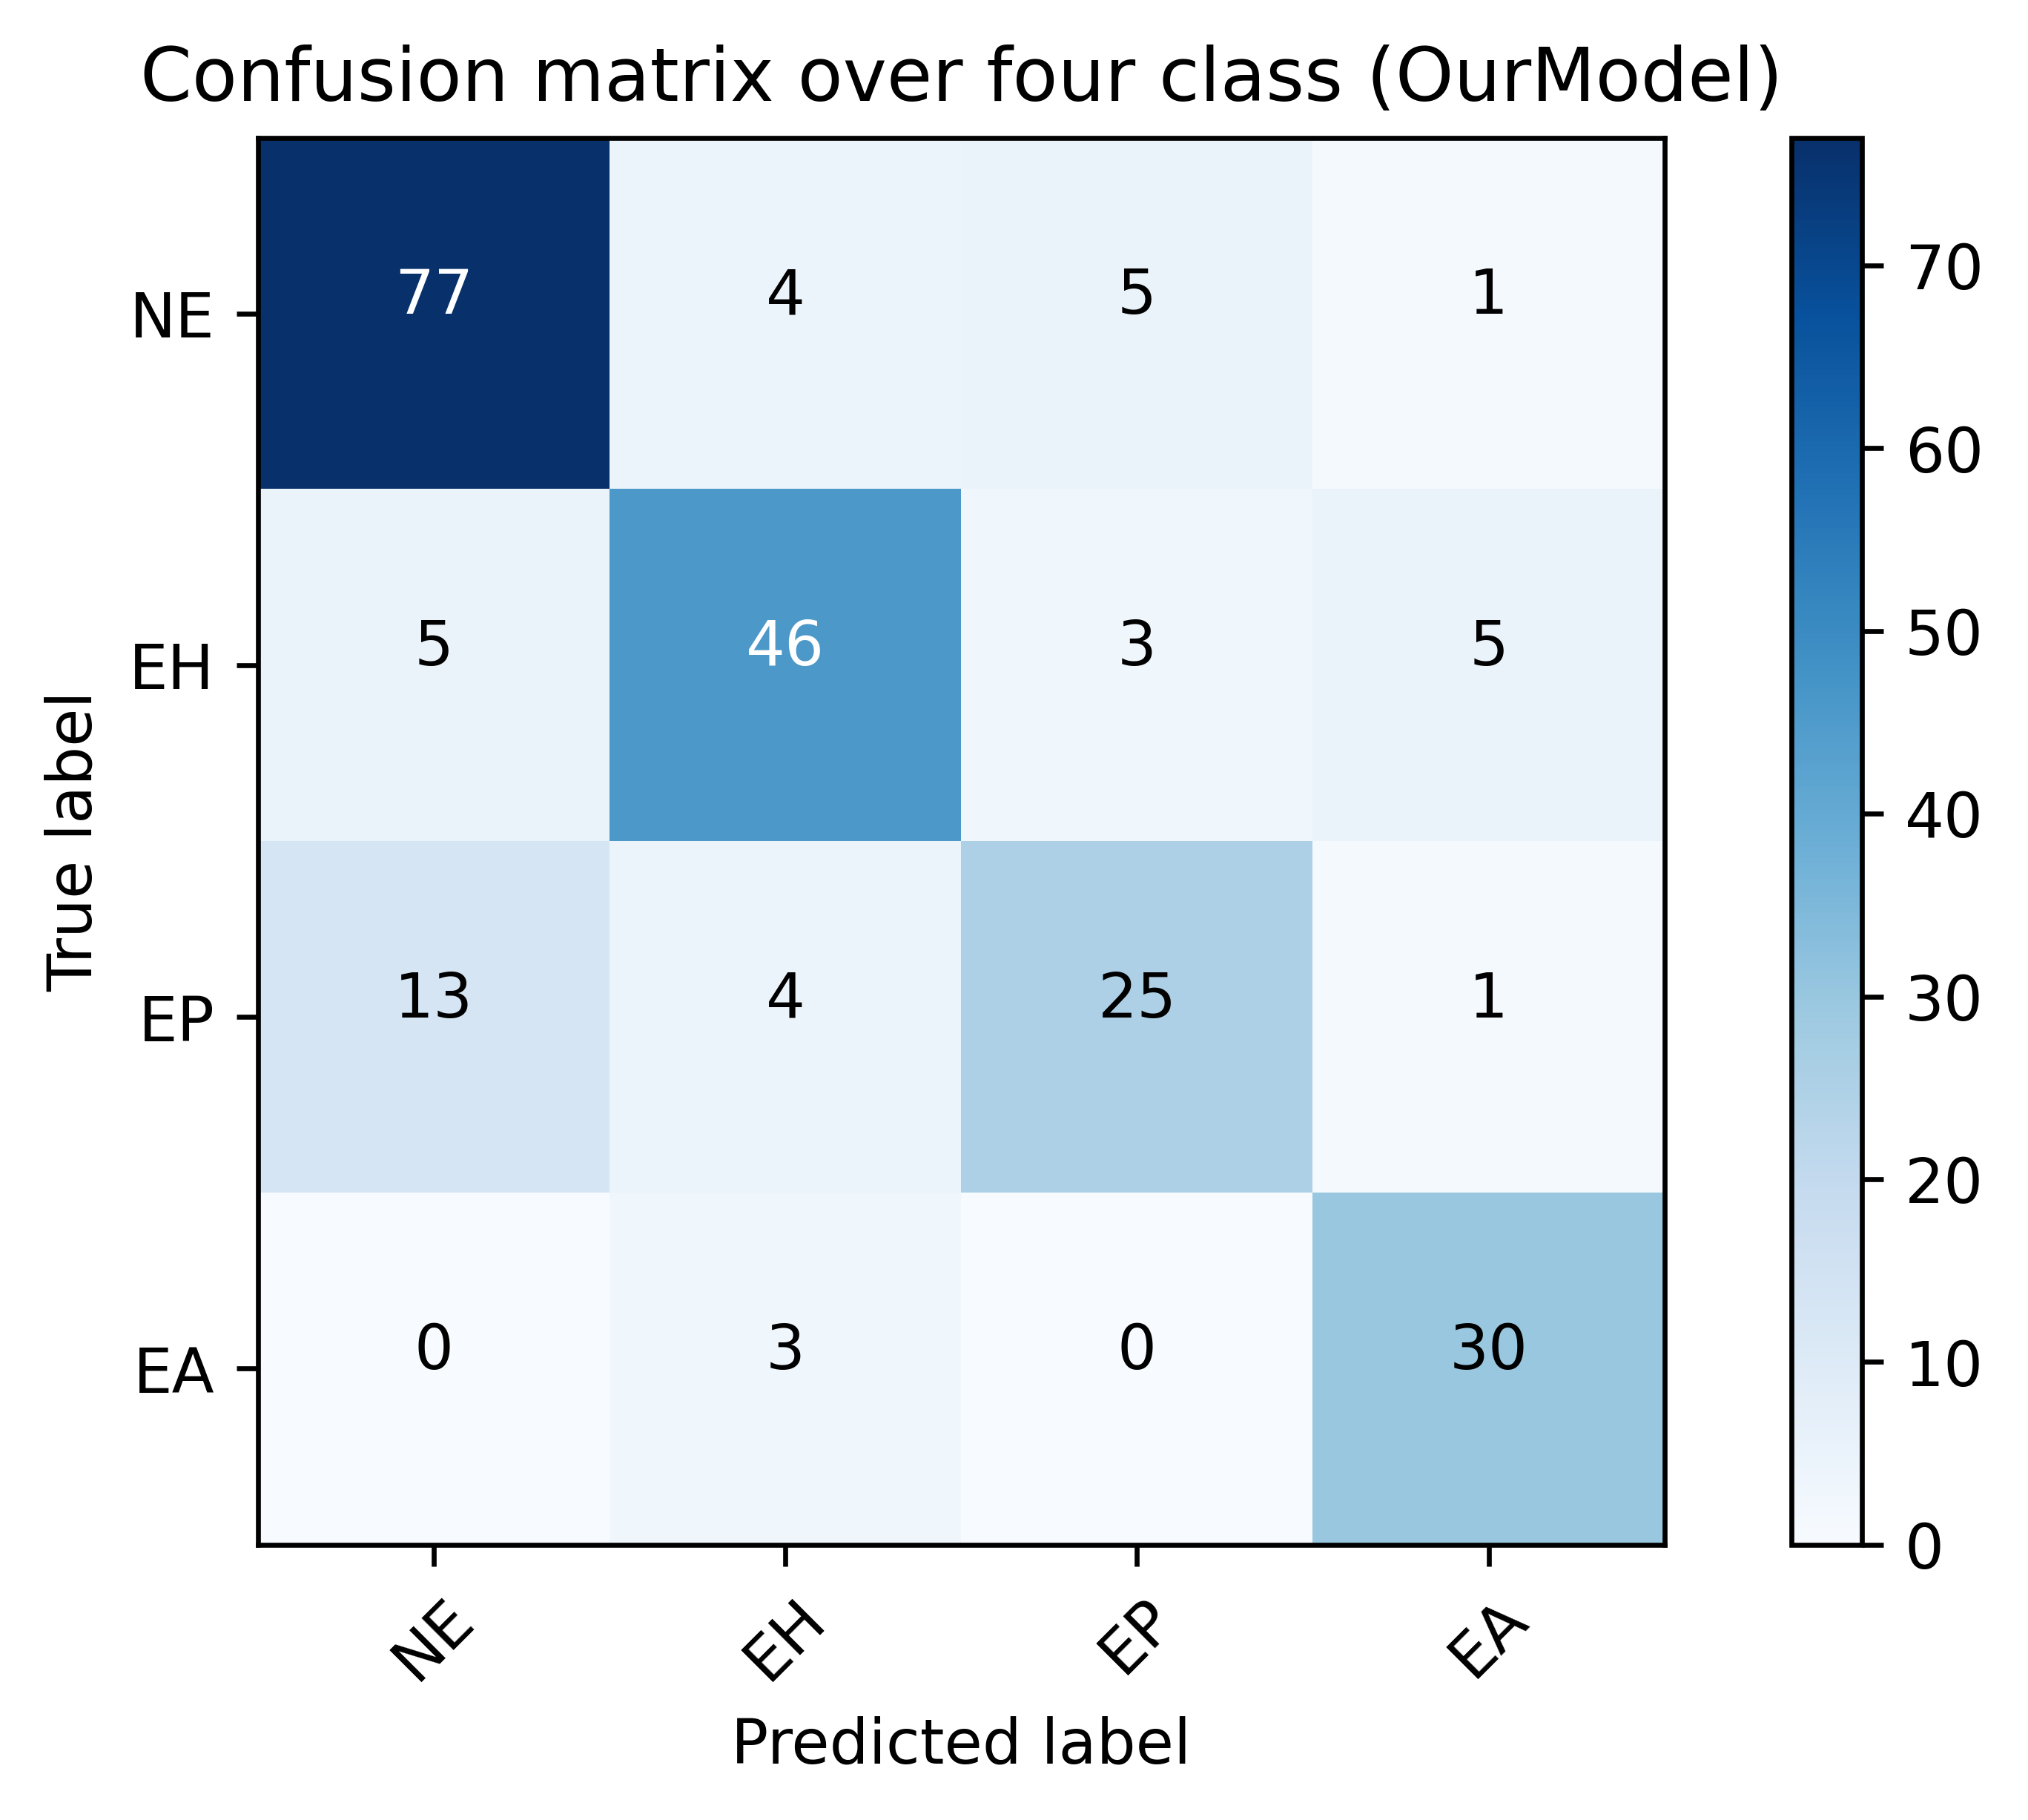

In [ ]:





import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics


# generate the class name
class_names = np.asarray(['NE', 'EH', 'EP', 'EA']).reshape((4, ))
c_n = np.asarray(['nil', 'hc']).reshape((2, ))
# generate y_pre and y_test, also class name
y_test = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
y_pred = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 2, 1, 3, 1, 1, 0, 1, 0, 1, 1, 3, 3, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 3, 0, 1, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 0, 2, 0, 2, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1]
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#get the classification report
print(classification_report(y_test, y_pred, target_names=class_names))
print("accuracy of model\t",metrics.accuracy_score(y_test, y_pred)*100)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix over four class (OurModel)')
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['figure.dpi'] = 600
plt.show()

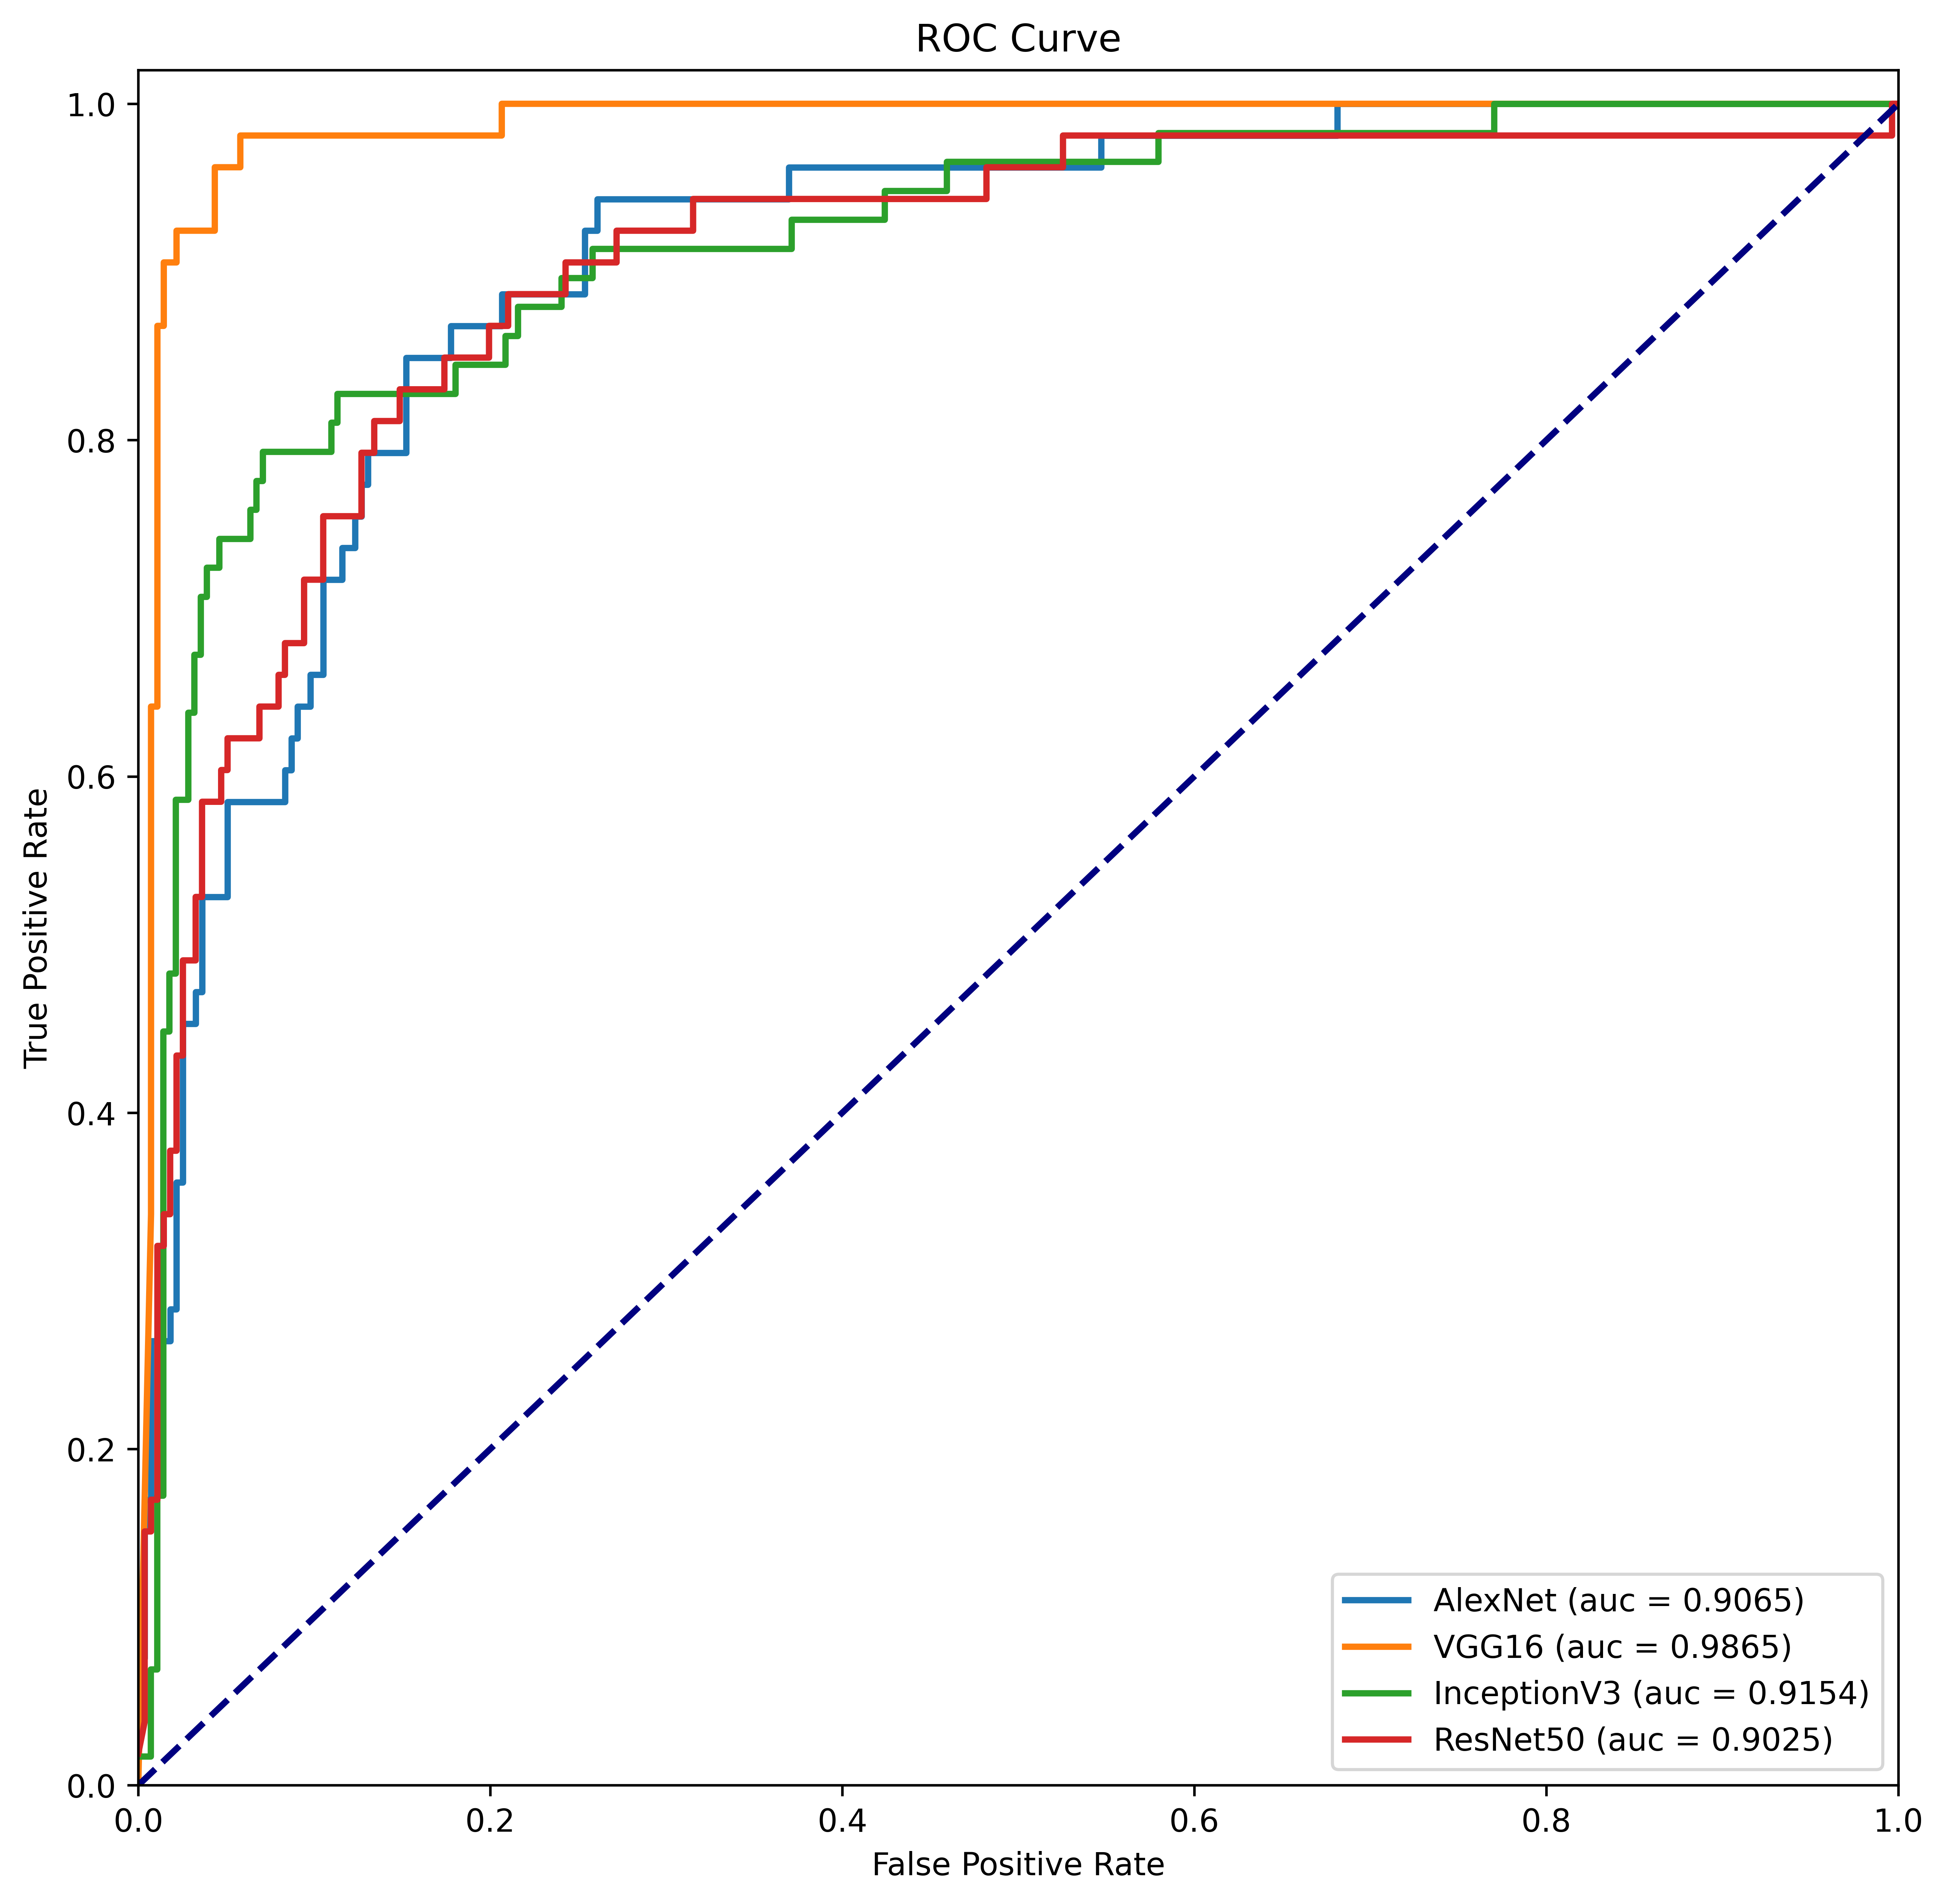

In [ ]:
import matplotlib.pyplot as plt
fpr_alex = [0.0, 0.0, 0.0036231884057971015, 0.0036231884057971015, 0.007246376811594203, 0.007246376811594203, 0.018115942028985508, 0.018115942028985508, 0.021739130434782608, 0.021739130434782608, 0.025362318840579712, 0.025362318840579712, 0.03260869565217391, 0.03260869565217391, 0.036231884057971016, 0.036231884057971016, 0.050724637681159424, 0.050724637681159424, 0.08333333333333333, 0.08333333333333333, 0.08695652173913043, 0.08695652173913043, 0.09057971014492754, 0.09057971014492754, 0.09782608695652174, 0.09782608695652174, 0.10507246376811594, 0.10507246376811594, 0.11594202898550725, 0.11594202898550725, 0.12318840579710146, 0.12318840579710146, 0.12681159420289856, 0.12681159420289856, 0.13043478260869565, 0.13043478260869565, 0.15217391304347827, 0.15217391304347827, 0.17753623188405798, 0.17753623188405798, 0.20652173913043478, 0.20652173913043478, 0.2536231884057971, 0.2536231884057971, 0.2608695652173913, 0.2608695652173913, 0.3695652173913043, 0.3695652173913043, 0.5471014492753623, 0.5471014492753623, 0.6811594202898551, 0.6811594202898551, 0.9420289855072463, 1.0]
tpr_alex = [0.03773584905660377, 0.07547169811320754, 0.07547169811320754, 0.16981132075471697, 0.16981132075471697, 0.2641509433962264, 0.2641509433962264, 0.2830188679245283, 0.2830188679245283, 0.3584905660377358, 0.3584905660377358, 0.4528301886792453, 0.4528301886792453, 0.4716981132075472, 0.4716981132075472, 0.5283018867924528, 0.5283018867924528, 0.5849056603773585, 0.5849056603773585, 0.6037735849056604, 0.6037735849056604, 0.6226415094339622, 0.6226415094339622, 0.6415094339622641, 0.6415094339622641, 0.660377358490566, 0.660377358490566, 0.7169811320754716, 0.7169811320754716, 0.7358490566037735, 0.7358490566037735, 0.7547169811320755, 0.7547169811320755, 0.7735849056603774, 0.7735849056603774, 0.7924528301886793, 0.7924528301886793, 0.8490566037735849, 0.8490566037735849, 0.8679245283018868, 0.8679245283018868, 0.8867924528301887, 0.8867924528301887, 0.9245283018867925, 0.9245283018867925, 0.9433962264150944, 0.9433962264150944, 0.9622641509433962, 0.9622641509433962, 0.9811320754716981, 0.9811320754716981, 1.0, 1.0, 1.0]
auc_alex=0.9064807219031994

fpr_vgg16=[0.0, 0.007246376811594203, 0.007246376811594203, 0.007246376811594203, 0.010869565217391304, 0.010869565217391304, 0.014492753623188406, 0.014492753623188406, 0.021739130434782608, 0.021739130434782608, 0.03260869565217391, 0.03985507246376811, 0.043478260869565216, 0.043478260869565216, 0.057971014492753624, 0.057971014492753624, 0.20652173913043478, 0.20652173913043478, 1.0]
tpr_vgg16=[0.0, 0.33962264150943394, 0.37735849056603776, 0.6415094339622641, 0.6415094339622641, 0.8679245283018868, 0.8679245283018868, 0.9056603773584906, 0.9056603773584906, 0.9245283018867925, 0.9245283018867925, 0.9245283018867925, 0.9245283018867925, 0.9622641509433962, 0.9622641509433962, 0.9811320754716981, 0.9811320754716981, 1.0, 1.0]
auc_vgg16=0.9865326770576975


fpr_inception=[0.0, 0.007067137809187279, 0.007067137809187279, 0.01060070671378092, 0.01060070671378092, 0.014134275618374558, 0.014134275618374558, 0.0176678445229682, 0.0176678445229682, 0.02120141342756184, 0.02120141342756184, 0.028268551236749116, 0.028268551236749116, 0.03180212014134275, 0.03180212014134275, 0.0353356890459364, 0.0353356890459364, 0.038869257950530034, 0.038869257950530034, 0.045936395759717315, 0.045936395759717315, 0.0636042402826855, 0.0636042402826855, 0.06713780918727916, 0.06713780918727916, 0.0706713780918728, 0.0706713780918728, 0.10954063604240283, 0.10954063604240283, 0.11307420494699646, 0.11307420494699646, 0.18021201413427562, 0.18021201413427562, 0.20848056537102475, 0.20848056537102475, 0.21554770318021202, 0.21554770318021202, 0.24028268551236748, 0.24028268551236748, 0.2579505300353357, 0.2579505300353357, 0.3710247349823322, 0.3710247349823322, 0.42402826855123676, 0.42402826855123676, 0.45936395759717313, 0.45936395759717313, 0.5795053003533569, 0.5795053003533569, 0.7703180212014135, 0.7703180212014135, 0.9646643109540636, 1.0]

tpr_inception=[0.017241379310344827, 0.017241379310344827, 0.06896551724137931, 0.06896551724137931, 0.1724137931034483, 0.1724137931034483, 0.4482758620689655, 0.4482758620689655, 0.4827586206896552, 0.4827586206896552, 0.5862068965517241, 0.5862068965517241, 0.6379310344827587, 0.6379310344827587, 0.6724137931034483, 0.6724137931034483, 0.7068965517241379, 0.7068965517241379, 0.7241379310344828, 0.7241379310344828, 0.7413793103448276, 0.7413793103448276, 0.7586206896551724, 0.7586206896551724, 0.7758620689655172, 0.7758620689655172, 0.7931034482758621, 0.7931034482758621, 0.8103448275862069, 0.8103448275862069, 0.8275862068965517, 0.8275862068965517, 0.8448275862068966, 0.8448275862068966, 0.8620689655172413, 0.8620689655172413, 0.8793103448275862, 0.8793103448275862, 0.896551724137931, 0.896551724137931, 0.9137931034482759, 0.9137931034482759, 0.9310344827586207, 0.9310344827586207, 0.9482758620689655, 0.9482758620689655, 0.9655172413793104, 0.9655172413793104, 0.9827586206896551, 0.9827586206896551, 1.0, 1.0, 1.0]

auc_inception=0.9153771170951627


fpr_resnet= [0.0, 0.0036231884057971015, 0.0036231884057971015, 0.007246376811594203, 0.007246376811594203, 0.010869565217391304, 0.010869565217391304, 0.014492753623188406, 0.014492753623188406, 0.018115942028985508, 0.018115942028985508, 0.021739130434782608, 0.021739130434782608, 0.025362318840579712, 0.025362318840579712, 0.03260869565217391, 0.03260869565217391, 0.036231884057971016, 0.036231884057971016, 0.04710144927536232, 0.04710144927536232, 0.050724637681159424, 0.050724637681159424, 0.06884057971014493, 0.06884057971014493, 0.07971014492753623, 0.07971014492753623, 0.08333333333333333, 0.08333333333333333, 0.09420289855072464, 0.09420289855072464, 0.10507246376811594, 0.10507246376811594, 0.12681159420289856, 0.12681159420289856, 0.13405797101449277, 0.13405797101449277, 0.14855072463768115, 0.14855072463768115, 0.17391304347826086, 0.17391304347826086, 0.19927536231884058, 0.19927536231884058, 0.21014492753623187, 0.21014492753623187, 0.2427536231884058, 0.2427536231884058, 0.2717391304347826, 0.2717391304347826, 0.31521739130434784, 0.31521739130434784, 0.48188405797101447, 0.48188405797101447, 0.5253623188405797, 0.5253623188405797, 0.5760869565217391, 0.5833333333333334, 0.9963768115942029, 0.9963768115942029, 1.0]

tpr_resnet=[0.018867924528301886, 0.03773584905660377, 0.1509433962264151, 0.1509433962264151, 0.16981132075471697, 0.16981132075471697, 0.32075471698113206, 0.32075471698113206, 0.33962264150943394, 0.33962264150943394, 0.37735849056603776, 0.37735849056603776, 0.4339622641509434, 0.4339622641509434, 0.49056603773584906, 0.49056603773584906, 0.5283018867924528, 0.5283018867924528, 0.5849056603773585, 0.5849056603773585, 0.6037735849056604, 0.6037735849056604, 0.6226415094339622, 0.6226415094339622, 0.6415094339622641, 0.6415094339622641, 0.660377358490566, 0.660377358490566, 0.6792452830188679, 0.6792452830188679, 0.7169811320754716, 0.7169811320754716, 0.7547169811320755, 0.7547169811320755, 0.7924528301886793, 0.7924528301886793, 0.8113207547169812, 0.8113207547169812, 0.8301886792452831, 0.8301886792452831, 0.8490566037735849, 0.8490566037735849, 0.8679245283018868, 0.8679245283018868, 0.8867924528301887, 0.8867924528301887, 0.9056603773584906, 0.9056603773584906, 0.9245283018867925, 0.9245283018867925, 0.9433962264150944, 0.9433962264150944, 0.9622641509433962, 0.9622641509433962, 0.9811320754716981, 0.9811320754716981, 0.9811320754716981, 0.9811320754716981, 1.0, 1.0]
auc_resnet=0.9025499042931364


lw = 2
plt.figure(figsize=(10, 10))
plt.plot(fpr_alex, tpr_alex,
         lw=lw, label='AlexNet (auc = %0.4f)' % auc_alex)

plt.plot(fpr_vgg16, tpr_vgg16,
         lw=lw, label='VGG16 (auc = %0.4f)' % auc_vgg16)

plt.plot(fpr_inception, tpr_inception,
         lw=lw, label='InceptionV3 (auc = %0.4f)' % auc_inception)

plt.plot(fpr_resnet, tpr_resnet,
         lw=lw, label='ResNet50 (auc = %0.4f)' % auc_resnet)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['figure.dpi'] = 600
plt.show()
